In [52]:
#!pip install gurobipy

In [53]:
# Load all required libraries
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample  # for bootstrapping
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize


In [54]:
url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-3/main/price_demand_data.csv"
df = pd.read_csv(url)

In [55]:
df.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


# Part 6

In [56]:
X = df_boot[["price"]].to_numpy()
y = df_boot["demand"].to_numpy()

ols = LinearRegression()
ols.fit(X, y)

a = float(ols.intercept_)
b = float(ols.coef_[0])
r2 = float(ols.score(X, y))

residuals = y - (a + b*X[:,0])

print(f"intercept: {a:.6f}")
print(f"slope: {b:.6f}")
print(f"r squared: {r2:.6f}")

intercept: 2024.262087
slope: -1434.857007
r squared: 0.656085


In [57]:
c = 0.5
g = 0.75
t = 0.15
p_fixed = 1.0

d1 = a + b*p_fixed + residuals # demand vector at p=1
n = d1.size
print("Scenarios at p=1:", n, "points")

Scenarios at p=1: 99 points


In [58]:
#model
mb = gp.Model()

p = mb.addMVar(1, lb=0.0, name="p") # price
q = mb.addMVar(1, lb=0.0, name="q") # quantity

s = mb.addMVar(n, lb=0.0, name="s") # sales
r = mb.addMVar(n, lb=0.0, name="r") # rush
d = mb.addMVar(n, lb=0.0, name="d") # disposal

In [59]:
#constraints
d3 = a + b * p[0] + residuals # demand vector under decision p
mb.addConstr(s <= q[0])
mb.addConstr(s <= d3)
mb.addConstr(r >= d3 - q[0])
mb.addConstr(d >= q[0] - d3)

<MConstr (99,) *awaiting model update*>

In [60]:
#objective and solve
obj_boot = (p[0] * gp.quicksum(s) - c * n * q[0] - g * gp.quicksum(r) - t * gp.quicksum(d)) / n
mb.setObjective(obj_boot, GRB.MAXIMIZE)
mb.Params.OutputFlag = 0
mb.optimize()

p_star = float(p.X[0])
q_star_joint = float(q.X[0])
profit_joint = float(mb.objVal)

In [61]:
print(f"optimal price: {p_star:.6f}")
print(f"optimal quantity: {q_star_joint:.6f}")
print(f"Expected profit: {profit_joint:.6f}")

optimal price: 0.944199
optimal quantity: 724.534931
Expected profit: 202.371441


# Part 7

In [62]:
def boot(n, df):
    prices = []
    quantities = []
    profits = []

    for i in range(n):
        df_boot = resample(df, replace=True, n_samples=len(df))
        df_boot.head()

        X = df_boot[["price"]].to_numpy()
        y = df_boot["demand"].to_numpy()

        ols = LinearRegression()
        ols.fit(X, y)

        a = float(ols.intercept_)
        b = float(ols.coef_[0])
        r2 = float(ols.score(X, y))

        residuals = y - (a + b*X[:,0])

        c = 0.5
        g = 0.75
        t = 0.15
        p_fixed = 1.0

        d1 = a + b*p_fixed + residuals # demand vector at p=1
        n = d1.size

        #model
        mb = gp.Model()

        p = mb.addMVar(1, lb=0.0, name="p") # price
        q = mb.addMVar(1, lb=0.0, name="q") # quantity

        s = mb.addMVar(n, lb=0.0, name="s") # sales
        r = mb.addMVar(n, lb=0.0, name="r") # rush
        d = mb.addMVar(n, lb=0.0, name="d") # disposal

        #constraints
        d3 = a + b * p[0] + residuals # demand vector under decision p
        mb.addConstr(s <= q[0])
        mb.addConstr(s <= d3)
        mb.addConstr(r >= d3 - q[0])
        mb.addConstr(d >= q[0] - d3)

        #objective and solve
        obj_boot = (p[0] * gp.quicksum(s) - c * n * q[0] - g * gp.quicksum(r) - t * gp.quicksum(d)) / n
        mb.setObjective(obj_boot, GRB.MAXIMIZE)
        mb.Params.OutputFlag = 0
        mb.optimize()

        p_star = float(p.X[0])
        q_star_joint = float(q.X[0])
        profit_joint = float(mb.objVal)

        prices += [p_star]
        quantities += [q_star_joint]
        profits += [profit_joint]

    results = pd.DataFrame({
        'price': prices,
        'quantity': quantities,
        'profit': profits
    })

    return results

In [63]:
results = boot(4000, df)

In [64]:
import matplotlib.pyplot as plt

plt.style.use("default")
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["axes.grid"] = True

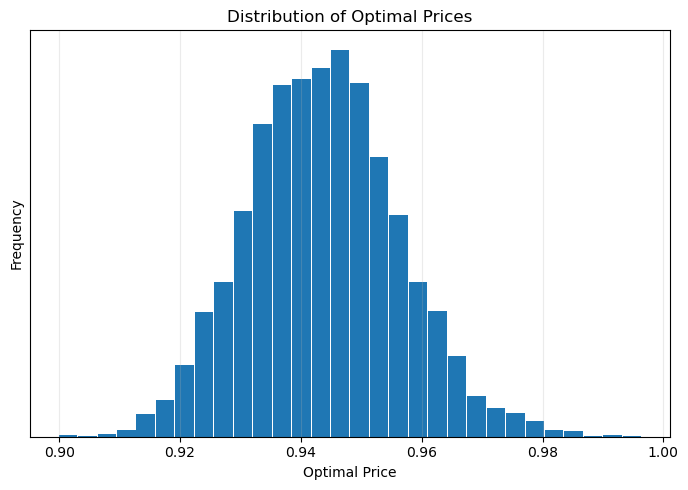

In [65]:
plt.figure(figsize=(7,5))
plt.hist(results['price'], bins=30, rwidth=0.95)
plt.xlabel("Optimal Price")
plt.ylabel("Frequency")
plt.title("Distribution of Optimal Prices")
plt.yticks([])
plt.tight_layout()
plt.show()

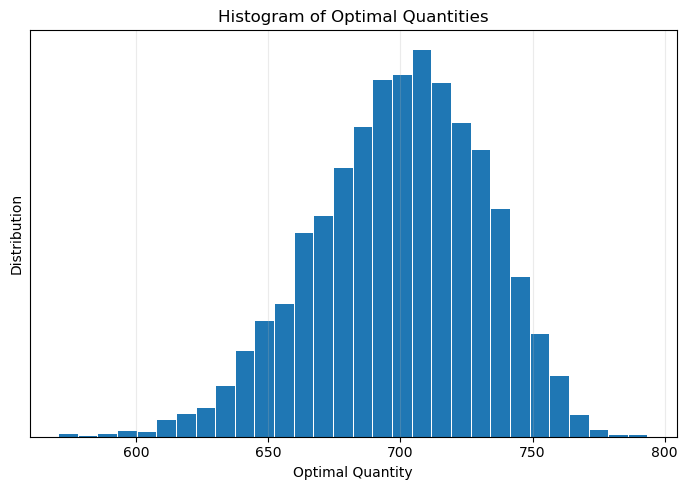

In [66]:
plt.figure(figsize=(7,5))
plt.hist(results['quantity'], bins=30, rwidth=0.95)
plt.xlabel("Optimal Quantity")
plt.ylabel("Distribution")
plt.title("Histogram of Optimal Quantities")
plt.yticks([])
plt.tight_layout()
plt.show()

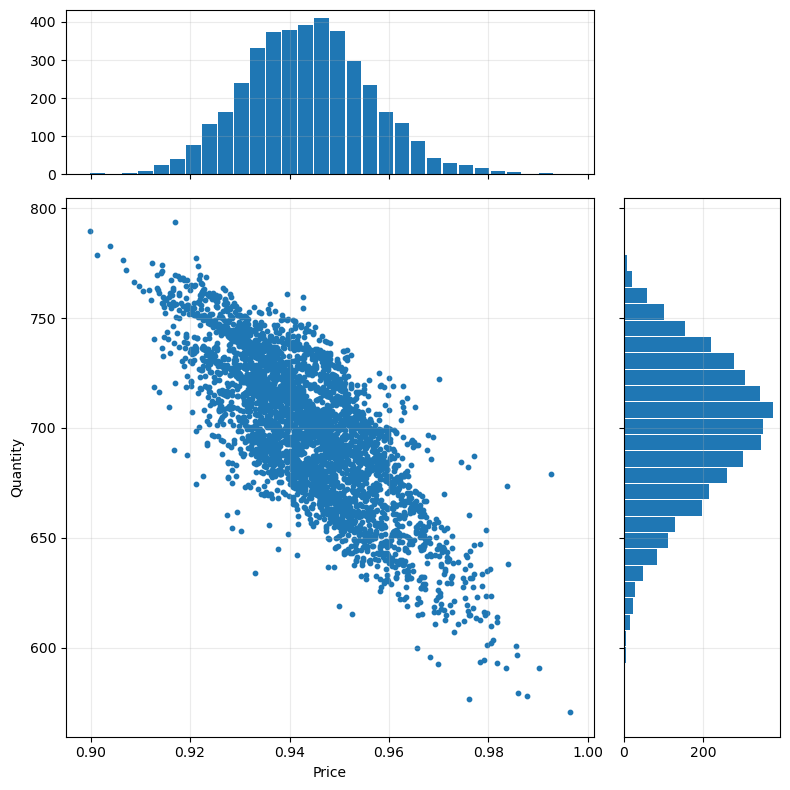

In [70]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,8))
gs = GridSpec(4,4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx   = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# scatter
ax_scatter.scatter(results['price'], results['quantity'], s=10)
ax_scatter.set_xlabel("Price")
ax_scatter.set_ylabel("Quantity")

# histograms with slight spacing
ax_histx.hist(results['price'], bins=30, rwidth=0.93)
ax_histy.hist(results['quantity'], bins=30, orientation='horizontal', rwidth=0.95)

# clean up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

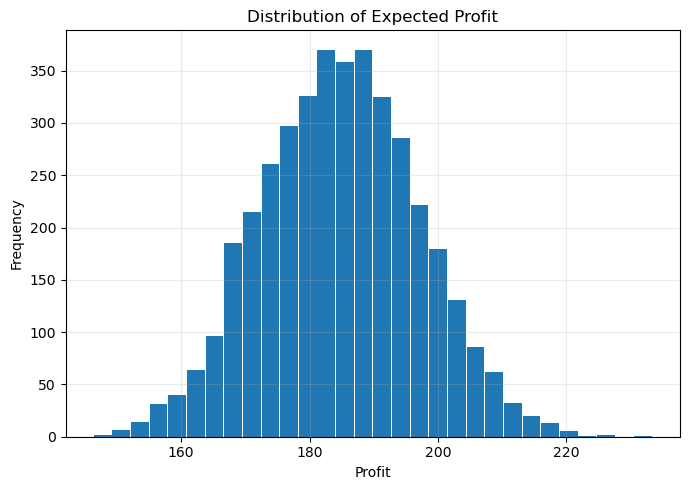

In [68]:
plt.figure(figsize=(7,5))
plt.hist(results['profit'], bins=30, rwidth=0.95)
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.title("Distribution of Expected Profit")
plt.tight_layout()
plt.show()